# Perceval Detailed Walkthrough

In this notebook, we aim to reproduce the $\mathsf{CNOT}$ gate with photonics and evaluate its performance while demonstrating key features of Perceval. We use as basis the implementation from [1].

In [20]:
import perceval as pcvl
import perceval.lib.phys as phys
import sympy as sp
import numpy as np

### Reproducing the Ralph CNOT Gate

We start by describing the circuit as defined by the paper above. It is a circuit on six modes (labelled from 0 to 5 from top to bottom) consisting of five beam splitters. Modes 1 and 2 contain the control system while modes 3 and 4 encode the target syestem. Modes 0 and 5 are ancillary modes.

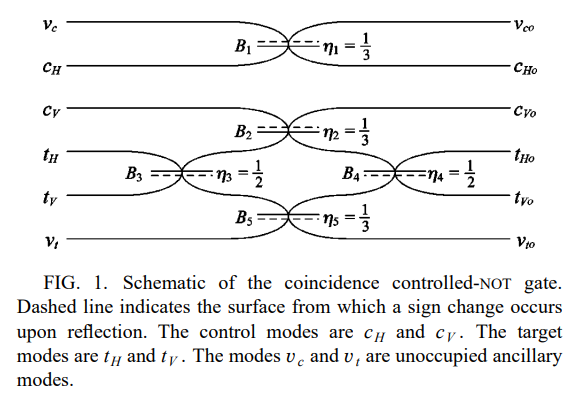

The aim of this first part is to reproduce a CNOT gate. We start by showing a small example on a different circuit than the one above to introduce some useful Perceval functions. 

In [21]:
test = phys.Circuit(6, name="test")
test.add(0,phys.PS(0.1))
test.add((2, 3), phys.BS(R=2/3))
test.add((1, 2), phys.BS())
test.add((4,5),phys.BS())
pcvl.pdisplay(test)

We can simulate this circuit using the `Naive` backend. 

In [22]:
simulator_backend = pcvl.BackendFactory().get_backend("Naive")
s_test = simulator_backend(test.U)

Because we want to analyse a gate, we have to see how it acts on different input states. Using dual-rail encoding, the logical computational basis states $\vert 0,0 \rangle$, $\vert 0,1 \rangle$, $\vert 1,0 \rangle$ and $\vert 1,1 \rangle$ can be expressed as (respectively) $\vert 0, 1, 0, 1, 0, 0 \rangle$, $\vert 0, 1, 0, 0, 1, 0 \rangle$, $\vert 0, 0, 1, 1, 0, 0 \rangle$, $\vert 0, 0, 1, 0, 1, 0 \rangle$ in the photon number basis (with the first and last mode left to $0$ as they are ancillary photons). We thus define the input states as:

In [23]:
states = {
    pcvl.BasicState([0, 1, 0, 1, 0, 0]): "00",
    pcvl.BasicState([0, 1, 0, 0, 1, 0]): "01",
    pcvl.BasicState([0, 0, 1, 1, 0, 0]): "10",
    pcvl.BasicState([0, 0, 1, 0, 1, 0]): "11"}


We use `CircuitAnalyser` to analyse the performance of the gate as such:

In [24]:
ca = pcvl.CircuitAnalyser(s_test, states)
ca.compute(expected={"00": "00", "01": "01", "10": "11", "11": "10"}) 
pcvl.pdisplay(ca)
print("performance=%s, error rate=%.3f%%" % (pcvl.simple_float(ca.performance)[1], ca.error_rate))

,00,01,10,11
00,0.499999,0,0.499999,0
01,0,0.499999,0,0.499999
10,0.499996,0,0.499996,0
11,0,0.499997,0,0.499997


performance=0, error rate=0.750%


We clearly did not obtain a reliable CNOT gate. We would like to have the following distribution: 

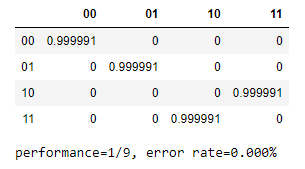

Following the same steps as before, create a Perceval circuit called `cnot` that reproduces the Ralph CNOT gate given in the picture above.

Beyond the actual logic gate, what is interesting with this gate is that it can be used to create an entangled states. We will now try to implement the CHSH experiment (the easiest Bell test). We can model it with an imperfect source. You can find more information on the CHSH wikipedia page: https://en.wikipedia.org/wiki/CHSH_inequality

### Checking for entanglement with CHSH experiment
![https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Two_channel_bell_test.svg/1340px-Two_channel_bell_test.svg.png)
*https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg*

To reproduce this Bell test protocol, we define a new circuit which uses the $\mathsf{CNOT}$ gate implemented above as a sub-circuit. The parameters $a$ and $b$ describe the measurement bases used by players $A$ and $B$ during runs of the Bell test.

We first create a Bell pair between the two logical qubits using this scheme.

<img src="images/bellstates.png" width="750" align="center">

We create a circuit `CHSH` which implement the circuit above. Note that the Hadamard gate is easily obtained with a 50:50 beam-splitter. 

In [31]:
CHSH = phys.Circuit(6)
CHSH.add((1, 2), phys.BS())

CHSH//= cnot

We now add two parametrisable Perceval parameters `a` and `b` that control the beam-splitters of parties A and B to implement varying measurements.

In [33]:
a = 
b = 

pcvl.pdisplay(CHSH, recursive = True)

We start by setting the values of the two parameters `a`and `b` to 0 with `set_value()`. This means that the beam splitters after the $\mathsf{CNOT}$ effectively act as the identity. 

We now define a photon source with a brightness of 40% and a purity of 99% with `pcvl.Source()`. We then define a `pcvl.Processor` which plugs two such sources to the circuit above on ports 1 and 3 (using the 0-index convention).

In [39]:
source = pcvl.Source(brightness=0.4, purity=0.99)
QPU = pcvl.Processor({1:source, 3:source}, test_cnot)

We can now see the input states of the simulation with the noisy sources below. The most frequent input is the empty state wi th no photons. The expected input state $|0,1,0,1,0,0\rangle$ arrives in third position which is normal if we loose photons. You can vary the brightness and observe for instance that with unit brightness we obtain the desired input $|0,1,0,1,0,0\rangle$. 

In [40]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-4) # output the output distribution with a precision of 10^-4

state,probability
"|0,0,0,0,0,0>",9/25
"|0,0,0,1,0,0>",0.2376
"|0,1,0,0,0,0>",0.2376
"|0,1,0,1,0,0>",0.1568
"|0,0,0,2,0,0>",0.0024
"|0,2,0,0,0,0>",0.0024
"|0,2,0,1,0,0>",0.0016
"|0,1,0,2,0,0>",0.0016
"|0,2,0,2,0,0>",0


Compute the output distribution corresponding to input distribution with brightness $0.4$.

Let's run now the experiment with decreasing value of purity in the range $[0.98,1]$ and check the CHSH inequality.

In [ ]:
from tqdm.auto import tqdm
x = np.arange(0, 2, 0.05) #purity=1-x/100
y = []

for imp in tqdm(x):
    Es = []
    
    
    # Fill the loop with more loops
    

    S = Es[0]-Es[1]+Es[2]+Es[3]          # Bell correlator
    print("purity=",1-imp/100, "S=", S)
    y.append(S)

### Graph of the bell inegality as a function of the impurity

In [ ]:
import matplotlib.pyplot as plt
plt.title("CHSH value with purity")
plt.xlabel("impurity (%)")
plt.ylabel("bell inegality")
plt.axhline(y=2, linewidth=2, color="red", label= 'horizontal-line')
plt.plot(x, y, color ="green")
plt.grid(color='b', dashes=(3, 2, 1, 2))
plt.show()

Beyond only 1% of impurity, we are crossing the value $2$, ie not violating anymore the $|CHSH|\le 2$ inegality!

[1] T. C. Ralph, N. K. Langford, T. B. Bell, and A. G. White. Linear optical controlled-NOT gate in the coincidence basis. Physical Review A, 65(6):062324, June 2002. Publisher: American Physical Society. URL: https://link.aps.org/doi/10.1103/PhysRevA.65.062324